In [ ]:
pip install catboost

In [ ]:
pip install hyperopt

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import random
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
train.head(5)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

# gender 성별

In [ ]:
print(train.gender.value_counts())
print(test.gender.value_counts())

F    17697
M     8760
Name: gender, dtype: int64
F    6733
M    3267
Name: gender, dtype: int64


# car 차량 소유 여부

In [ ]:
print(train.car.value_counts())
print(test.car.value_counts())

N    16410
Y    10047
Name: car, dtype: int64
N    6204
Y    3796
Name: car, dtype: int64


# reality 부동산 소유 여부

In [ ]:
print(train.reality.value_counts())
print(test.reality.value_counts())

Y    17830
N     8627
Name: reality, dtype: int64
Y    6676
N    3324
Name: reality, dtype: int64


- 범주형 변수 그룹화 (성별, 차량 소유 여부, 부동산 소유 여부)

In [ ]:
train.gender.value_counts().index

Index(['F', 'M'], dtype='object')

In [ ]:
train['gender_car_reality'] = (train.gender + '_' + train.car + '_' + train.reality).astype(str)
test['gender_car_reality'] = (test.gender + '_' + test.car + '_' + test.reality).astype(str)
train.groupby(['gender_car_reality'])['index'].count().reset_index(name = 'count').sort_values(by = 'count')

,gender_car_reality,count
4,M_N_N,1231
2,F_Y_N,1465
6,M_Y_N,1911
5,M_N_Y,2013
3,F_Y_Y,3066
7,M_Y_Y,3605
0,F_N_N,4020
1,F_N_Y,9146


# FLAG_MOBIL 핸드폰 소유 여부
- 모두 1, 카드를 사용한 사람들은 모두 모바일 핸드폰을 소유하고 있다.
- 필요없는 변수

In [ ]:
print(train.FLAG_MOBIL.value_counts())
print(test.FLAG_MOBIL.value_counts())

1    26457
Name: FLAG_MOBIL, dtype: int64
1    10000
Name: FLAG_MOBIL, dtype: int64


# work_phone 업무용 전화 소유 여부

In [ ]:
print(train.work_phone.value_counts())
print(test.work_phone.value_counts())

0    20511
1     5946
Name: work_phone, dtype: int64
0    7724
1    2276
Name: work_phone, dtype: int64


# phone 전화 소유 여부

In [ ]:
print(train.phone.value_counts())
print(train.phone.value_counts())

0    18672
1     7785
Name: phone, dtype: int64
0    18672
1     7785
Name: phone, dtype: int64


# email 이메일 소유 여부

In [ ]:
print(train.email.value_counts())
print(test.email.value_counts())

0    24042
1     2415
Name: email, dtype: int64
0    9144
1     856
Name: email, dtype: int64


- 매핑 후 범주형 변수 그룹화 (핸드폰 소유 여부, 업무용 폰 소유 여부, 전화 소유 여부, 이메일 소유 여부)

In [ ]:
for col in ['FLAG_MOBIL','work_phone','phone','email']:
  train[col] = train[col].map(lambda x: 'N' if x == 0 else 'Y')
  test[col] = test[col].map(lambda x: 'N' if x == 0 else 'Y')

In [ ]:
train['phones_email'] = (train.FLAG_MOBIL + '_' + train.work_phone + '_' + train.phone + '_' + train.email).astype(str)
test['phones_email'] = (test.FLAG_MOBIL + '_' + test.work_phone + '_' + test.phone + '_' + test.email).astype(str)
train.groupby(['phones_email'])['index'].count().reset_index(name = 'count').sort_values(by = 'count')

,phones_email,count
5,Y_Y_N_Y,166
7,Y_Y_Y_Y,278
3,Y_N_Y_Y,476
1,Y_N_N_Y,1495
4,Y_Y_N_N,2469
6,Y_Y_Y_N,3033
2,Y_N_Y_N,3998
0,Y_N_N_N,14542


# family_size 가족 규모

In [ ]:
print(train.family_size.value_counts())
print(test.family_size.value_counts())

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64
2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64


- 가족 수가 5 이상 부터는 규모가 큰 것으로 판단 5 이상부터는 동일하게 처리

In [ ]:
train['family_size'][train['family_size'] >= 5] = 5
test['family_size'][test['family_size'] >= 5] = 5

# income_total 전체소득

- 소득구간 나누기 방법1

In [ ]:
count, bins = np.histogram(train.income_total, bins = 5)
train['income_total_bins'] = pd.cut(train.income_total, bins = bins, labels = ['소득구간1','소득구간2','소득구간3','소득구간4','소득구간5'],include_lowest=True)
test['income_total_bins'] = pd.cut(test.income_total, bins = bins, labels = ['소득구간1','소득구간2','소득구간3','소득구간4','소득구간5'],include_lowest=True)
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,gender_car_reality,phones_email,income_total_bins
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,Y,N,N,N,NaN,2.0,-6.0,1.0,F_N_N,Y_N_N_N,소득구간1
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,Y,N,N,Y,Laborers,3.0,-5.0,1.0,F_N_Y,Y_N_N_Y,소득구간1
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,Y,N,Y,N,Managers,2.0,-22.0,2.0,M_Y_Y,Y_N_Y_N,소득구간2
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,Y,N,Y,N,Sales staff,2.0,-37.0,0.0,F_N_Y,Y_N_Y_N,소득구간1
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,Y,N,N,N,Managers,2.0,-26.0,2.0,F_Y_Y,Y_N_N_N,소득구간1


In [ ]:
label_encoder = LabelEncoder()
train['income_total_bins']=label_encoder.fit_transform(train['income_total_bins'])
test['income_total_bins']=label_encoder.fit_transform(test['income_total_bins'])

- 소득구간 나누기 방법2

In [ ]:
"""
def bins_divider(data):
  data['income_total_bins'] = 0
  data.loc[(data['income_total']*100 >= 1000000) & (data['income_total']*100 < 5000000 ),'income_total_bins'] = '소득구간1'
  data.loc[(data['income_total']*100 >= 5000000) & (data['income_total']*100 < 10000000 ),'income_total_bins'] = '소득구간2'
  data.loc[(data['income_total']*100 >= 10000000) & (data['income_total']*100 < 40000000),'income_total_bins'] = '소득구간3'
  data.loc[(data['income_total']*100 >= 40000000) & (data['income_total']*100 < 100000000),'income_total_bins'] = '소득구간4'
  data.loc[(data['income_total']*100 >= 100000000),'income_total_bins'] = '소득구간5'

bins_divider(train)
bins_divider(test)
"""

"\ndef bins_divider(data):\n  data['income_total_bins'] = 0\n  data.loc[(data['income_total']*100 >= 1000000) & (data['income_total']*100 < 5000000 ),'income_total_bins'] = '소득구간1'\n  data.loc[(data['income_total']*100 >= 5000000) & (data['income_total']*100 < 10000000 ),'income_total_bins'] = '소득구간2'\n  data.loc[(data['income_total']*100 >= 10000000) & (data['income_total']*100 < 40000000),'income_total_bins'] = '소득구간3'\n  data.loc[(data['income_total']*100 >= 40000000) & (data['income_total']*100 < 100000000),'income_total_bins'] = '소득구간4'\n  data.loc[(data['income_total']*100 >= 100000000),'income_total_bins'] = '소득구간5'\n\nbins_divider(train)\nbins_divider(test)\n"

# house_type 생활방식
['Municipal apartment', 'House/apartment', 'With parents','Co-op apartment', 'Rented apartment','Office apartment']

In [ ]:
print(train.house_type.value_counts())
print('='*30)
print(test.house_type.value_counts())

House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64
House / apartment      8895
With parents            519
Municipal apartment     310
Rented apartment        146
Office apartment         72
Co-op apartment          58
Name: house_type, dtype: int64


# occyp_type 직업 유형

- laborers 노동자 x
- core staff 핵심 직원 o
- sales staff 영업 직원 o
- managers 관리자 o
- drivers 운전기사 x
- high skill tech staff 전문 기술 직원 o
- accountants 회계사 o
- medicine staff 의료진 o
- cooking staff 요리 직원 x
- security staff 보안 요원 x
- cleaning staff 청소 직원 x
- private service staff 개인 서비스 직원 x
- Low-skill Laborers 저 숙련 노동자 x
- Waiters/barmen staff 웨이터 / 바멘 스태프 x
- Secretaries 비서 o
- Realty agents 부동산 에이전트 o
- HR staff HR 직원 o
- IT staff IT 직원 o

In [ ]:
print(train.occyp_type.value_counts())
print('='*30)
print(train.occyp_type.value_counts())

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretari

- 전문/비전문 직종 그룹화
- 비슷한 직종 그룹화
- 자격증 필요 직종 그룹화

In [ ]:
def professional(data):
  data['professional'] = 'N'
  prof = ['Core staff','Sales staff','Managers','High skill tech staff','Accountants','Medicine staff','Secretaries','Realty agents','HR staff','IT staff']
  for p in prof:
    data['professional'][data['occyp_type'] == p] = 'Y'

professional(train)
professional(test)

In [ ]:
print(train['professional'].value_counts())
print(test['professional'].value_counts())

N    16036
Y    10421
Name: professional, dtype: int64
N    6127
Y    3873
Name: professional, dtype: int64


- occyp_type 결측치의 경우 직업이 없는 백수로 판단

In [ ]:
train.isnull().sum() # occyp_type 에 결측치 존재
train = train.replace(np.nan, 'Nojob')
test = test.replace(np.nan, 'Nojob')

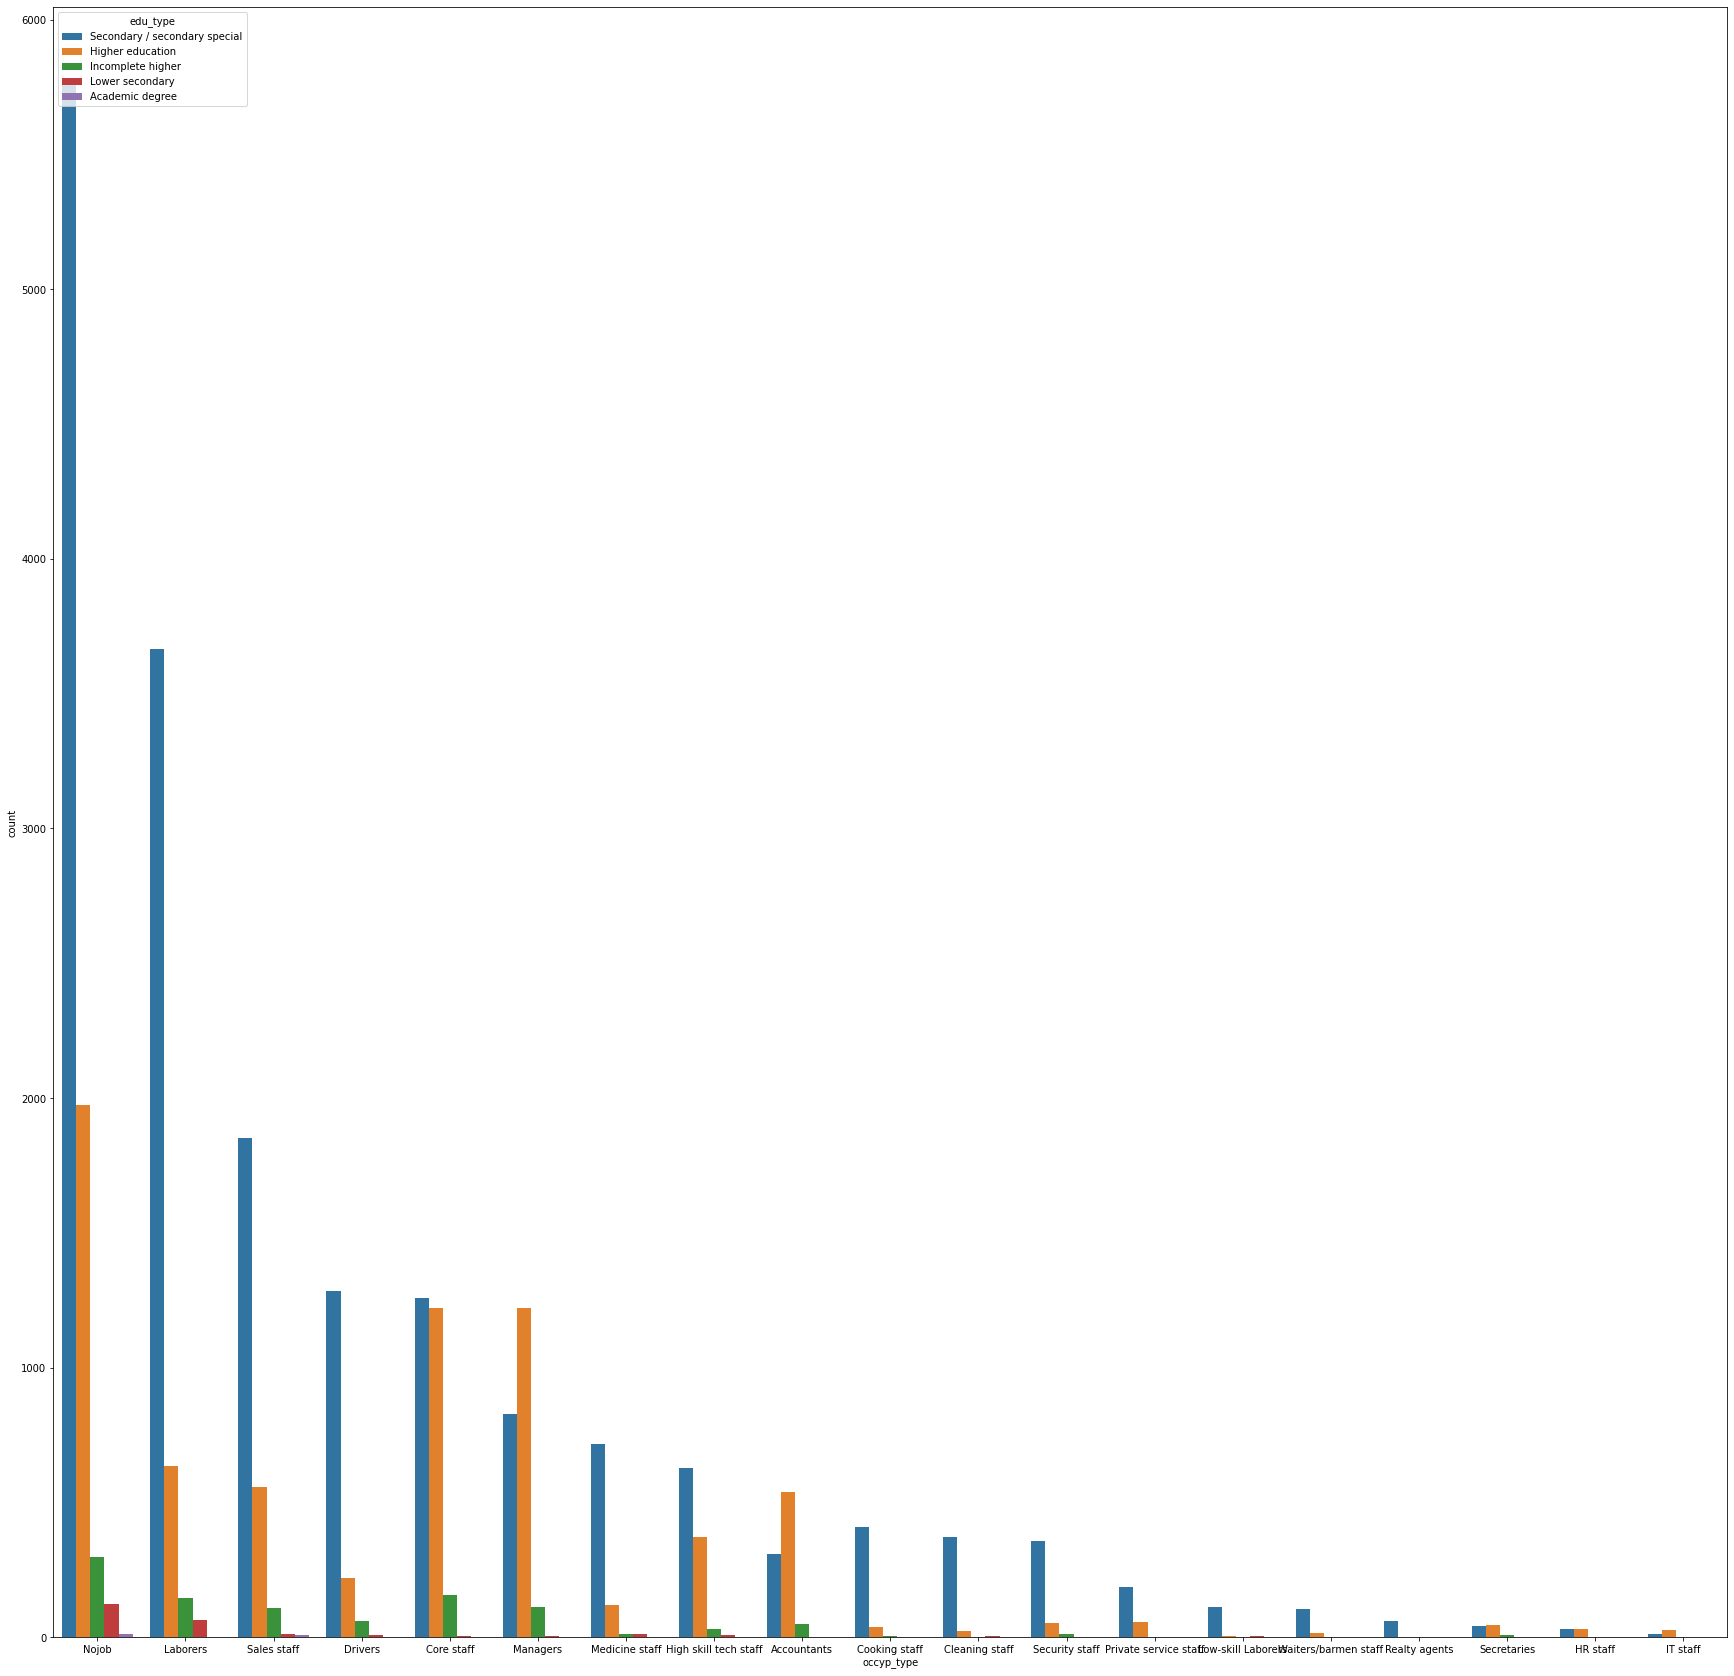

In [ ]:
#pd.DataFrame(train.groupby(['occyp_type','edu_type'])['edu_type'].count())
pre_df = train[['occyp_type','edu_type']].value_counts().reset_index()
pre_df.columns = ['occyp_type','edu_type','count']
pre_df

import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize = (30,30))
sns.barplot(pre_df['occyp_type'],pre_df['count'],hue=pre_df['edu_type'])
# train[['occyp_type','income_total']].groupby(['occyp_type']).mean().sort_values(by='income_total')

# imcome_type 소득 분류
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']

In [ ]:
train['occyp_type'][train['income_type']=='State servant'].value_counts()

Core staff               655
Nojob                    392
Medicine staff           274
Managers                 226
High skill tech staff    148
Laborers                 142
Drivers                   87
Accountants               69
Cooking staff             41
Waiters/barmen staff      31
Secretaries               22
Cleaning staff            16
Private service staff     15
Security staff            14
Sales staff               10
IT staff                   6
Low-skill Laborers         3
HR staff                   3
Name: occyp_type, dtype: int64

In [ ]:
print(train.income_type.value_counts())
print(test.income_type.value_counts())

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64
Working                 5174
Commercial associate    2288
Pensioner               1703
State servant            831
Student                    4
Name: income_type, dtype: int64


# family_type 결혼 여부
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

In [ ]:
print(train.family_type.value_counts())
print(test.family_type.value_counts())

Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64
Married                 6852
Single / not married    1333
Civil marriage           822
Separated                564
Widow                    429
Name: family_type, dtype: int64


- 싱글 / 미혼모 (구분)

In [ ]:
train['child_num'][train['family_type']=='Single / not married'].value_counts()


0     2987
1      440
2       56
3       12
19       1
Name: child_num, dtype: int64

In [ ]:
train['family_type'][(train['family_type'] == 'Single / not married') & (train['child_num'] > 0)] = 'not married'
train['family_type'][(train['family_type'] == 'Single / not married') & (train['child_num'] == 0)] = 'Single'

test['family_type'][(test['family_type'] == 'Single / not married') & (test['child_num'] > 0)] = 'not married'
test['family_type'][(test['family_type'] =='Single / not married') & (test['child_num'] == 0)] = 'Single'

In [ ]:
train['family_type'].value_counts()

Married           18196
Single             2987
Civil marriage     2123
Separated          1539
Widow              1103
not married         509
Name: family_type, dtype: int64

# edu_type 교육 수준
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']

['고등교육','중등교육','불완전한 고등(자퇴)','하급중등교육','학사학위']

In [ ]:
train.edu_type.value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

# credit 신용 기준(사용자의 신용카드 대금 연체를 기준으로 한 신용도)

# child_num 소아 수

In [ ]:
train.child_num.value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [ ]:
train[(train['family_size'] - train['child_num'])<0]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,gender_car_reality,phones_email,income_total_bins,professional
8462,8462,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,Y,N,N,N,Drivers,5.0,-7.0,2.0,M_Y_Y,Y_N_N_N,0,N
9021,9021,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,Y,N,N,N,Drivers,5.0,-58.0,2.0,M_Y_Y,Y_N_N_N,0,N
10731,10731,F,N,Y,19,112500.0,Working,Secondary / secondary special,not married,House / apartment,-11057,-1853,Y,Y,Y,N,Waiters/barmen staff,5.0,-5.0,2.0,F_N_Y,Y_Y_Y_N,0,N
14900,14900,M,Y,N,2,225000.0,Working,Secondary / secondary special,Married,House / apartment,-14776,-2212,Y,N,N,N,Drivers,1.0,-30.0,2.0,M_Y_N,Y_N_N_N,0,N
25313,25313,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13827,-1649,Y,Y,Y,N,Cleaning staff,5.0,-26.0,2.0,F_N_N,Y_Y_Y_N,0,N
25390,25390,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,Y,N,N,N,Drivers,5.0,-43.0,2.0,M_Y_Y,Y_N_N_N,0,N
25638,25638,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13827,-1649,Y,Y,Y,N,Cleaning staff,5.0,-31.0,2.0,F_N_N,Y_Y_Y_N,0,N


In [ ]:
test[(test['family_size'] - test['child_num'])<0]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,gender_car_reality,phones_email,income_total_bins,professional
4918,31375,M,Y,N,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14452,-4249,Y,N,N,N,Drivers,1.0,-35.0,M_Y_N,Y_N_N_N,0,N


- 자녀 수가  이상 부터는 규모가 큰 것으로 판단  이상부터는 동일하게 처리


In [ ]:
train.loc[train['child_num'] >=3,'child_num']=3
test.loc[test['child_num']>=3, 'child_num']=3

In [ ]:
#train['family_size'] = train['family_size'].astype(int)
#test['family_size'] = test['family_size'].astype(int)
#train.loc[14900,'child_num'] = 0
#test.loc[4918,'child_num'] = 0
#train.drop(14900,axis=0,inplace=True)
#test.drop(4918,axis=0,inplace=True)

# DAYS_BIRTH 출생일

In [ ]:
train.DAYS_BIRTH.value_counts()

-12676    40
-15519    38
-14667    32
-15140    26
-16768    24
          ..
-9353      1
-9901      1
-21655     1
-11767     1
-15726     1
Name: DAYS_BIRTH, Length: 6621, dtype: int64

In [ ]:
np.abs(train.DAYS_BIRTH/365)

0        38.079452
1        31.178082
2        52.293151
3        41.336986
4        41.197260
           ...    
26452    33.093151
26453    41.893151
26454    27.621918
26455    27.794521
26456    53.613699
Name: DAYS_BIRTH, Length: 26457, dtype: float64

- 부호 변환 ( 음수 -> 양수 )

In [ ]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
test['DAYS_BIRTH'] = abs(test['DAYS_BIRTH'])

- 나이 변환

In [ ]:
#train['AGE'] = train['DAYS_BIRTH']/365
#test['AGE'] = test['DAYS_BIRTH']/365

#train['AGE'] = train['DAYS_EMPLOYED']/365
#test['AGE'] = test['DAYS_EMPLOYED']/365

# DAYS_EMPLOYED 업무시작일


In [ ]:
train.DAYS_EMPLOYED.value_counts()

 365243    4438
-401         57
-1539        47
-200         45
-2087        44
           ... 
-8171         1
-12253        1
-6060         1
-1898         1
-2103         1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

In [ ]:
# np.abs(train.DAYS_EMPLOYED)/365

양수는 고용되지 않은 상태를 의미 0으로 변경

In [ ]:
train['DAYS_EMPLOYED'][train['DAYS_EMPLOYED'] > 0] = 0
test['DAYS_EMPLOYED'][test['DAYS_EMPLOYED'] > 0] = 0

In [ ]:
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
test['DAYS_EMPLOYED'] = abs(test['DAYS_EMPLOYED'])

- 날짜 변환 (월 , 주, 년)

In [ ]:
# DAYS_BIRTH
train['DAYS_BIRTH_month']=np.floor((train['DAYS_BIRTH'])/30)-((np.floor((train['DAYS_BIRTH'])/30)/12).astype(int)*12)
train['DAYS_BIRTH_week']=np.floor((train['DAYS_BIRTH'])/7)-((np.floor((train['DAYS_BIRTH'])/7)/4).astype(int)*4)
train['DAYS_BIRTH_year'] = round((train['DAYS_BIRTH']/12))

# DAYS_EMPLOYED
train['DAYS_EMPLOYED_month']=np.floor((train['DAYS_EMPLOYED'])/30)-((np.floor((train['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
train['DAYS_EMPLOYED_week']=np.floor((train['DAYS_EMPLOYED'])/7)-((np.floor((train['DAYS_EMPLOYED'])/7)/4).astype(int)*4)
train['DAYS_EMPLOYED_year'] = round((train['DAYS_EMPLOYED']/12))

# before_EMPLOYED
train['before_EMPLOYED']=train['DAYS_BIRTH']-train['DAYS_EMPLOYED']
train['before_EMPLOYED_month']=np.floor((train['before_EMPLOYED'])/30)-((np.floor((train['before_EMPLOYED'])/30)/12).astype(int)*12)
train['before_EMPLOYED_week']=np.floor((train['before_EMPLOYED'])/7)-((np.floor((train['before_EMPLOYED'])/7)/4).astype(int)*4)
train['before_EMPLOYED_year'] = train['DAYS_BIRTH_year'] - train['DAYS_EMPLOYED_year']

# DAYS_BIRTH
test['DAYS_BIRTH_month']=np.floor((test['DAYS_BIRTH'])/30)-((np.floor((test['DAYS_BIRTH'])/30)/12).astype(int)*12)
test['DAYS_BIRTH_week']=np.floor((test['DAYS_BIRTH'])/7)-((np.floor((test['DAYS_BIRTH'])/7)/4).astype(int)*4)
test['DAYS_BIRTH_year'] = round((test['DAYS_BIRTH']/12))

# DAYS_EMPLOYED
test['DAYS_EMPLOYED_month']=np.floor((test['DAYS_EMPLOYED'])/30)-((np.floor((test['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
test['DAYS_EMPLOYED_week']=np.floor((test['DAYS_EMPLOYED'])/7)-((np.floor((test['DAYS_EMPLOYED'])/7)/4).astype(int)*4)
test['DAYS_EMPLOYED_year'] = round((test['DAYS_EMPLOYED']/12))

# before_EMPLOYED
test['before_EMPLOYED']=test['DAYS_BIRTH']-test['DAYS_EMPLOYED']
test['before_EMPLOYED_month']=np.floor((test['before_EMPLOYED'])/30)-((np.floor((test['before_EMPLOYED'])/30)/12).astype(int)*12)
test['before_EMPLOYED_week']=np.floor((test['before_EMPLOYED'])/7)-((np.floor((test['before_EMPLOYED'])/7)/4).astype(int)*4)
test['before_EMPLOYED_year'] = test['DAYS_BIRTH_year'] - test['DAYS_EMPLOYED_year']

In [ ]:
train.iloc[:,-10:].head()

,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_BIRTH_year,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,DAYS_EMPLOYED_year,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_year
0,7.0,1.0,1158.0,0.0,0.0,392.0,9190,6.0,0.0,766.0
1,7.0,1.0,948.0,3.0,0.0,128.0,9840,4.0,1.0,820.0
2,0.0,2.0,1591.0,3.0,1.0,370.0,14653,8.0,1.0,1221.0
3,10.0,3.0,1257.0,9.0,2.0,174.0,12996,1.0,0.0,1083.0
4,9.0,0.0,1253.0,10.0,0.0,175.0,12932,11.0,3.0,1078.0


# begin_month 신용카드 발급 월

In [ ]:
train.begin_month.value_counts()

-7.0     662
-11.0    617
-8.0     612
-3.0     593
-6.0     591
        ... 
-58.0    244
-59.0    242
-60.0    235
 0.0     231
-57.0    228
Name: begin_month, Length: 61, dtype: int64

In [ ]:
np.abs(train.begin_month)/12

0        0.500000
1        0.416667
2        1.833333
3        3.083333
4        2.166667
           ...   
26452    0.166667
26453    3.916667
26454    2.083333
26455    4.916667
26456    0.750000
Name: begin_month, Length: 26457, dtype: float64

In [ ]:
train['begin_month'] = abs(train['begin_month'])
test['begin_month'] = abs(test['begin_month'])

- 날짜 변환 ( 월 -> 일)

In [ ]:
train['begin_year'] = (train.begin_month)/12
test['begin_year'] = (test.begin_month)/12

train['begin_week'] = (train.begin_month)*4.345
test['begin_week'] = (test.begin_month)*4.345

#train['begin_day'] = (train.begin_month)*30.417
#test['begin_day'] = (test.begin_month)*30.417

# ALL Version 인사이트

- 평균 연령 소득 이상/미만

In [ ]:
train['AGE'] = round(train.DAYS_BIRTH/365)
test['AGE'] = round(test.DAYS_BIRTH/365)

In [ ]:
mean_income = train[['AGE','income_total']].groupby(['AGE'])['income_total'].mean().reset_index()
mean_income['AGE_cut'] = pd.cut(mean_income.AGE, bins = 5, labels = ['20대','30대','40대','50대','60대'],include_lowest=True)

mean_income1 = test[['AGE','income_total']].groupby(['AGE'])['income_total'].mean().reset_index()
mean_income1['AGE_cut'] = pd.cut(mean_income1.AGE, bins = 5, labels = ['20대','30대','40대','50대','60대'],include_lowest=True)

In [ ]:
mean_cut_income = mean_income[['AGE_cut','income_total']].groupby(['AGE_cut'])['income_total'].mean().reset_index()
mean_cut_income['income_total'] = round(mean_cut_income['income_total']).astype(int)
train['income_total'] = train['income_total'].astype(int)

mean_cut_income1 = mean_income1[['AGE_cut','income_total']].groupby(['AGE_cut'])['income_total'].mean().reset_index()
mean_cut_income1['income_total'] = round(mean_cut_income1['income_total']).astype(int)
test['income_total'] = test['income_total'].astype(int)

In [ ]:
mean_cut_income

,AGE_cut,income_total
0,20대,170356
1,30대,194040
2,40대,201513
3,50대,182585
4,60대,147290


In [ ]:
mean_cut_income1

,AGE_cut,income_total
0,20대,168829
1,30대,189959
2,40대,203286
3,50대,179152
4,60대,160888


In [ ]:
#(train['income_total'][train['AGE'] < 30])
#(mean_cut_income['income_total'][mean_cut_income['AGE_cut'] == '20대'])

In [ ]:
# train
train['mean_income'] = 0

train['mean_income'][(train['AGE'] < 30) & (train['income_total'] >= 170356)] = '20대평균소득이상'
train['mean_income'][(train['AGE'] < 30) & (train['income_total'] < 170356)] = '20대평균소득미만'

train['mean_income'][((train['AGE'] >= 30) & (train['AGE'] < 40)) & (train['income_total'] >= 194040)] = '30대평균소득이상'
train['mean_income'][((train['AGE'] >= 30) & (train['AGE'] < 40)) & (train['income_total'] < 194040)] = '30대평균소득미만'

train['mean_income'][((train['AGE'] >= 40) & (train['AGE'] < 50)) & (train['income_total'] >= 201513)] = '40대평균소득이상'
train['mean_income'][((train['AGE'] >= 40) & (train['AGE'] < 50)) & (train['income_total'] < 201513)] = '40대평균소득미만'

train['mean_income'][((train['AGE'] >= 50) & (train['AGE'] < 60)) & (train['income_total'] >= 182585)] = '50대평균소득이상'
train['mean_income'][((train['AGE'] >= 50) & (train['AGE'] < 60)) & (train['income_total'] < 182585)] = '50대평균소득미만'

train['mean_income'][((train['AGE'] >= 60) & (train['AGE'] < 70)) & (train['income_total'] >= 147290)] = '60대평균소득이상'
train['mean_income'][((train['AGE'] >= 60) & (train['AGE'] < 70)) & (train['income_total'] < 147290)] = '60대평균소득미만'

# test
test['mean_income'] = 0

test['mean_income'][(test['AGE'] < 30) & (test['income_total'] >= 168829)] = '20대평균소득이상'
test['mean_income'][(test['AGE'] < 30) & (test['income_total'] < 168829)] = '20대평균소득미만'

test['mean_income'][((test['AGE'] >= 30) & (test['AGE'] < 40)) & (test['income_total'] >= 189959)] = '30대평균소득이상'
test['mean_income'][((test['AGE'] >= 30) & (test['AGE'] < 40)) & (test['income_total'] < 189959)] = '30대평균소득미만'

test['mean_income'][((test['AGE'] >= 40) & (test['AGE'] < 50)) & (test['income_total'] >= 203286)] = '40대평균소득이상'
test['mean_income'][((test['AGE'] >= 40) & (test['AGE'] < 50)) & (test['income_total'] < 203286)] = '40대평균소득미만'

test['mean_income'][((test['AGE'] >= 50) & (test['AGE'] < 60)) & (test['income_total'] >= 179152)] = '50대평균소득이상'
test['mean_income'][((test['AGE'] >= 50) & (test['AGE'] < 60)) & (test['income_total'] < 179152)] = '50대평균소득미만'

test['mean_income'][((test['AGE'] >= 60) & (test['AGE'] < 70)) & (test['income_total'] >= 160888)] = '60대평균소득이상'
test['mean_income'][((test['AGE'] >= 60) & (test['AGE'] < 70)) & (test['income_total'] < 160888)] = '60대평균소득미만'

In [ ]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,gender_car_reality,phones_email,income_total_bins,professional,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_BIRTH_year,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,DAYS_EMPLOYED_year,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_year,begin_year,begin_week,AGE,mean_income
0,0,F,N,N,0,202500,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,Y,N,N,N,Nojob,2.0,6.0,1.0,F_N_N,Y_N_N_N,0,N,7.0,1.0,1158.0,0.0,0.0,392.0,9190,6.0,0.0,766.0,0.500000,26.070,38.0,30대평균소득이상
1,1,F,N,Y,1,247500,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,Y,N,N,Y,Laborers,3.0,5.0,1.0,F_N_Y,Y_N_N_Y,0,N,7.0,1.0,948.0,3.0,0.0,128.0,9840,4.0,1.0,820.0,0.416667,21.725,31.0,30대평균소득이상
2,2,M,Y,Y,0,450000,Working,Higher education,Married,House / apartment,19087,4434,Y,N,Y,N,Managers,2.0,22.0,2.0,M_Y_Y,Y_N_Y_N,1,Y,0.0,2.0,1591.0,3.0,1.0,370.0,14653,8.0,1.0,1221.0,1.833333,95.590,52.0,50대평균소득이상
3,3,F,N,Y,0,202500,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,Y,N,Y,N,Sales staff,2.0,37.0,0.0,F_N_Y,Y_N_Y_N,0,Y,10.0,3.0,1257.0,9.0,2.0,174.0,12996,1.0,0.0,1083.0,3.083333,160.765,41.0,40대평균소득이상
4,4,F,Y,Y,0,157500,State servant,Higher education,Married,House / apartment,15037,2105,Y,N,N,N,Managers,2.0,26.0,2.0,F_Y_Y,Y_N_N_N,0,Y,9.0,0.0,1253.0,10.0,0.0,175.0,12932,11.0,3.0,1078.0,2.166667,112.970,41.0,40대평균소득미만
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000,State servant,Secondary / secondary special,Married,House / apartment,12079,1984,Y,N,N,N,Core staff,4.0,2.0,1.0,F_N_N,Y_N_N_N,0,Y,6.0,1.0,1007.0,6.0,3.0,165.0,10095,0.0,2.0,842.0,0.166667,8.690,33.0,30대평균소득이상
26453,26453,F,N,Y,1,180000,Working,Higher education,Separated,House / apartment,15291,2475,Y,N,N,N,Nojob,2.0,47.0,2.0,F_N_Y,Y_N_N_N,0,N,5.0,0.0,1274.0,10.0,1.0,206.0,12816,7.0,2.0,1068.0,3.916667,204.215,42.0,40대평균소득미만
26454,26454,F,Y,N,0,292500,Working,Secondary / secondary special,Civil marriage,With parents,10082,2015,Y,N,N,N,Core staff,2.0,25.0,2.0,F_Y_N,Y_N_N_N,0,Y,0.0,0.0,840.0,7.0,3.0,168.0,8067,4.0,0.0,672.0,2.083333,108.625,28.0,20대평균소득이상
26455,26455,M,N,Y,0,171000,Working,Incomplete higher,Single,House / apartment,10145,107,Y,N,N,N,Laborers,1.0,59.0,2.0,M_N_Y,Y_N_N_N,0,N,2.0,1.0,845.0,3.0,3.0,9.0,10038,10.0,2.0,836.0,4.916667,256.355,28.0,20대평균소득이상


- 가족 수 - 자녀 수


In [ ]:
# train['family_size by child_num'] = np.abs(train['family_size'] - train['child_num'])
# test['family_size by child_num'] = np.abs(test['family_size'] - test['child_num'])

- 동일인물 처리
> 중복인물 중 가장 처음or마지막 행만 남기기

  > 중복인물을 구별하는 새로운 컬럼 생성
    
    > 중복될만한 컬럼 파악하기

In [ ]:
#train['duplicated'] = 0
#train['duplicated'][(train.drop(['index'],axis=1).duplicated(keep=False)) == True] = 1
#train.drop(train.loc[train['duplicated']>0,'duplicated'],axis=0,inplace=True)

#test['duplicated'] = 0
#test['duplicated'][(test.drop(['index'],axis=1).duplicated(keep=False)) == True] = 1
#test.drop(test.loc[test['duplicated']>0,'duplicated'],axis=0,inplace=True)

In [ ]:
test.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'gender_car_reality',
       'phones_email', 'income_total_bins', 'professional', 'DAYS_BIRTH_month',
       'DAYS_BIRTH_week', 'DAYS_BIRTH_year', 'DAYS_EMPLOYED_month',
       'DAYS_EMPLOYED_week', 'DAYS_EMPLOYED_year', 'before_EMPLOYED',
       'before_EMPLOYED_month', 'before_EMPLOYED_week', 'before_EMPLOYED_year',
       'begin_year', 'begin_week', 'AGE', 'mean_income'],
      dtype='object')

In [ ]:
"""
train['duplicated'] = '중복x'
train['duplicated_first'] = '중복x'
train['duplicated_last'] = '중복x'
train['duplicated'][train.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep=False)] = '중복o'
train['duplicated_last'][train.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep='last')] = '중복o/마지막값'
train['duplicated_first'][train.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep='first')] = '중복o/첫번째값'

def train_duplicated():
  train['duplicated'][train['duplicated_last'] == '중복o/마지막값'] = '중복o/마지막값'
  train['duplicated'][train['duplicated_first'] == '중복o/첫번째값'] = '중복o/첫번째값'
  train.drop(['duplicated_last','duplicated_first'],axis=1,inplace=True)

test['duplicated'] = '중복x'
test['duplicated_first'] = '중복x'
test['duplicated_last'] = '중복x'
test['duplicated'][test.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep=False)] = '중복o'
test['duplicated_last'][test.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep='last')] = '중복o/마지막값'
test['duplicated_first'][test.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep='first')] = '중복o/첫번째값'
def test_duplicated():
  test['duplicated'][test['duplicated_last'] == '중복o/마지막값'] = '중복o/마지막값'
  test['duplicated'][test['duplicated_first'] == '중복o/첫번째값'] = '중복o/첫번째값'
  test.drop(['duplicated_last','duplicated_first'],axis=1,inplace=True)

train_duplicated()
test_duplicated()
"""

"\ntrain['duplicated'] = '중복x'\ntrain['duplicated_first'] = '중복x'\ntrain['duplicated_last'] = '중복x'\ntrain['duplicated'][train.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep=False)] = '중복o'\ntrain['duplicated_last'][train.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep='last')] = '중복o/마지막값'\ntrain['duplicated_first'][train.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep='first')] = '중복o/첫번째값'\n\ndef train_duplicated():\n  train['duplicated'][train['duplicated_last'] == '중복o/마지막값'] = '중복o/마지막값'\n  train['duplicated'][train['duplicated_first'] == '중복o/첫번째값'] = '중복o/첫번째값'\n  train.drop(['duplicated_last','duplicated_first'],axis=1,inplace=True)\n\ntest['duplicated'] = '중복x'\ntest['duplicated_first'] = '중복x'\ntest['duplicated_last'] = '중복x'\ntest['duplicated'][test.duplicated(['gender_car_reality','income_total','DAYS_BIRTH','DAYS_EMPLOYED'],keep=False)] = '중복o'\ntest['duplicated_last'

In [ ]:
#train['duplicated'].value_counts()

In [ ]:
# 모든 컬럼에 해당하는 중복인물 중 가장 첫번째만 남기고 처리
#train.drop_duplicates(train.drop(['index','begin_month','begin_day','begin_week','begin_year','credit'],axis=1).columns,keep='last',inplace=True) # keep='last'
#test.drop_duplicates(test.drop(['index','begin_month','begin_day','begin_week','begin_year'],axis=1).columns,keep='last',inplace=True) # keep='last'

In [ ]:
len(train.drop(['begin_month','credit'],axis=1).columns),len(test.drop(['begin_month'],axis=1).columns)

(36, 36)

In [ ]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit',
       'gender_car_reality', 'phones_email', 'income_total_bins',
       'professional', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week',
       'DAYS_BIRTH_year', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week',
       'DAYS_EMPLOYED_year', 'before_EMPLOYED', 'before_EMPLOYED_month',
       'before_EMPLOYED_week', 'before_EMPLOYED_year', 'begin_year',
       'begin_week', 'AGE', 'mean_income'],
      dtype='object')

In [ ]:
#train['duplicated'] = [str(a0)+'_'+str(a1)+'_'+str(a2)+'_'+str(a3)+'_'+str(a4)+'_'+str(a5)+'_'+str(a6)+'_'+str(a7)+'_'+str(a8) for a0,a1,a2,a3,a4,a5,a6,a7,a8 in zip(train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'],train['income_total_bins'],train['DAYS_BIRTH_month'],train['DAYS_BIRTH_year'],train['DAYS_EMPLOYED_month'],train['DAYS_EMPLOYED_year'],train['mean_income'])]
#test['duplicated'] = [str(a0)+'_'+str(a1)+'_'+str(a2)+'_'+str(a3)+'_'+str(a4)+'_'+str(a5)+'_'+str(a6)+'_'+str(a7)+'_'+str(a8) for a0,a1,a2,a3,a4,a5,a6,a7,a8 in zip(test['income_type'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED'],test['income_total_bins'],test['DAYS_BIRTH_month'],test['DAYS_BIRTH_year'],test['DAYS_EMPLOYED_month'],test['DAYS_EMPLOYED_year'],test['mean_income'])]
#train['identity'] = [str(i) + str(j) + str(k) + str(l) for i,j,k,l in zip(train['gender'],train['income_total_bins'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED_year'])]
#test['identity'] = [str(i) + str(j) + str(k) + str(l) for i,j,k,l in zip(test['gender'],test['income_total_bins'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED_year'])]

- 필요없는 변수 처리

In [ ]:
train.drop(['index'],axis=1,inplace=True)
test.drop(['index'],axis=1,inplace=True)
train.drop(['gender'],axis=1,inplace=True)
test.drop(['gender'],axis=1,inplace=True)
train.drop(['car'],axis=1,inplace=True)
test.drop(['car'],axis=1,inplace=True)
train.drop(['reality'],axis=1,inplace=True)
test.drop(['reality'],axis=1,inplace=True)
train.drop(['phone'],axis=1,inplace=True)
test.drop(['phone'],axis=1,inplace=True)
train.drop(['email'],axis=1,inplace=True)
test.drop(['email'],axis=1,inplace=True)
train.drop(['work_phone'],axis=1,inplace=True)
test.drop(['work_phone'],axis=1,inplace=True)
train.drop(['FLAG_MOBIL'],axis=1,inplace=True)
test.drop(['FLAG_MOBIL'],axis=1,inplace=True)
#train.drop(['DAYS_BIRTH'],axis=1,inplace=True)
#test.drop(['DAYS_BIRTH'],axis=1,inplace=True)
#train.drop(['DAYS_EMPLOYED'],axis=1,inplace=True)
#test.drop(['DAYS_EMPLOYED'],axis=1,inplace=True)
#train.drop(['family_size'],axis=1,inplace=True)
#test.drop(['family_size'],axis=1,inplace=True)
#train.drop(['child_num'],axis=1,inplace=True)
#test.drop(['child_num'],axis=1,inplace=True)
train.drop(['professional'],axis=1,inplace=True)
test.drop(['professional'],axis=1,inplace=True)
#train.drop(['AGE'],axis=1,inplace=True)
#test.drop(['AGE'],axis=1,inplace=True)

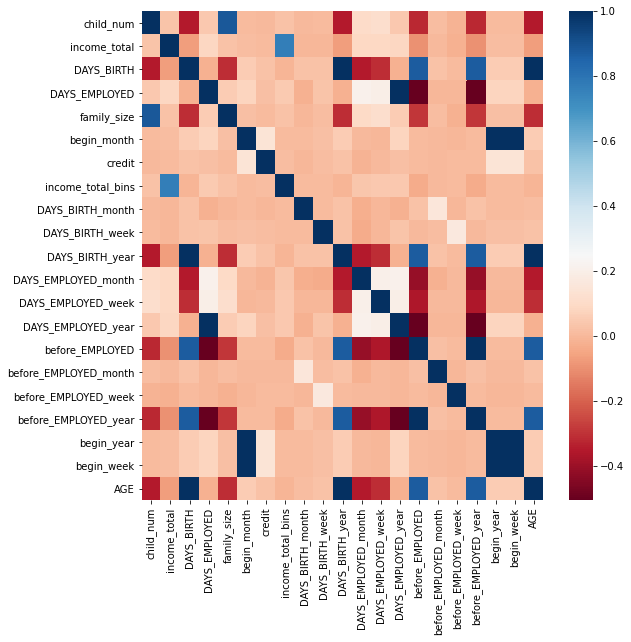

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(9,9))
corr = train.corr()
sns.heatmap(corr,cmap='RdBu')

In [ ]:
#train.drop(['DAYS_BIRTH_month'],axis=1,inplace=True)
#test.drop(['DAYS_BIRTH_month'],axis=1,inplace=True)
#train.drop(['before_EMPLOYED_month'],axis=1,inplace=True)
#test.drop(['before_EMPLOYED_month'],axis=1,inplace=True)
#train.drop(['DAYS_BIRTH_week'],axis=1,inplace=True)
#test.drop(['DAYS_BIRTH_week'],axis=1,inplace=True)
#train.drop(['before_EMPLOYED_week'],axis=1,inplace=True)
#test.drop(['before_EMPLOYED_week'],axis=1,inplace=True)

In [ ]:
train.drop(['begin_month','credit'],axis=1).columns
len(train.drop(['begin_month','credit'],axis=1).columns)

27

In [ ]:
#label_encoder = LabelEncoder()
#train['duplicated']=label_encoder.fit_transform(train['duplicated'])
#test['duplicated']=label_encoder.fit_transform(test['duplicated'])

#label_encoder = LabelEncoder()
#train['identity']=label_encoder.fit_transform(train['identity'])
#test['identity']=label_encoder.fit_transform(test['identity'])

In [ ]:
#train['duplicated'].value_counts()
#train['identity'].value_counts()

In [ ]:
train.columns

Index(['child_num', 'income_total', 'income_type', 'edu_type', 'family_type',
       'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'occyp_type',
       'family_size', 'begin_month', 'credit', 'gender_car_reality',
       'phones_email', 'income_total_bins', 'DAYS_BIRTH_month',
       'DAYS_BIRTH_week', 'DAYS_BIRTH_year', 'DAYS_EMPLOYED_month',
       'DAYS_EMPLOYED_week', 'DAYS_EMPLOYED_year', 'before_EMPLOYED',
       'before_EMPLOYED_month', 'before_EMPLOYED_week', 'before_EMPLOYED_year',
       'begin_year', 'begin_week', 'AGE', 'mean_income'],
      dtype='object')

- 라벨 인코딩 & 원 핫 인코딩

In [ ]:
enc_col = []
for col in train.columns:
    if train[col].dtype == 'object':
      enc_col = []
      enc_col.append(col)

enc = OneHotEncoder()
enc.fit(train.loc[:,enc_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,enc_col]).toarray(),columns = enc.get_feature_names(enc_col))
train.drop(enc_col,axis=1,inplace=True)
train = pd.concat([train,train_onehot_df],axis=1)

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,enc_col]).toarray(),columns = enc.get_feature_names(enc_col))
test.drop(enc_col,axis=1,inplace=True)
test = pd.concat([test,test_onehot_df],axis=1)

In [ ]:
lab_col = []
lab = LabelEncoder()
for col in train.columns:
    if train[col].dtype == 'object':
      lab_col = []
      lab_col.append(col)
      print(lab_col)
      train[lab_col]=lab.fit_transform(train[lab_col])
      test[lab_col]=lab.fit_transform(test[lab_col])

['income_type']
['edu_type']
['family_type']
['house_type']
['occyp_type']
['gender_car_reality']
['phones_email']


In [ ]:
train.isnull().sum(),test.isnull().sum()

(child_num                0
 income_total             0
 income_type              0
 edu_type                 0
 family_type              0
 house_type               0
 DAYS_BIRTH               0
 DAYS_EMPLOYED            0
 occyp_type               0
 family_size              0
 begin_month              0
 credit                   0
 gender_car_reality       0
 phones_email             0
 income_total_bins        0
 DAYS_BIRTH_month         0
 DAYS_BIRTH_week          0
 DAYS_BIRTH_year          0
 DAYS_EMPLOYED_month      0
 DAYS_EMPLOYED_week       0
 DAYS_EMPLOYED_year       0
 before_EMPLOYED          0
 before_EMPLOYED_month    0
 before_EMPLOYED_week     0
 before_EMPLOYED_year     0
 begin_year               0
 begin_week               0
 AGE                      0
 mean_income_20대평균소득미만    0
 mean_income_20대평균소득이상    0
 mean_income_30대평균소득미만    0
 mean_income_30대평균소득이상    0
 mean_income_40대평균소득미만    0
 mean_income_40대평균소득이상    0
 mean_income_50대평균소득미만    0
 mean_income_50대평균소득

- 정수형 변환

In [ ]:
for col in train.columns:
    if train[col].dtype == 'float':
      train[col] = train[col].astype(int)

for col in test.columns:
    if test[col].dtype == 'float':
      test[col] = test[col].astype(int)

In [ ]:
train

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,credit,gender_car_reality,phones_email,income_total_bins,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_BIRTH_year,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,DAYS_EMPLOYED_year,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_year,begin_year,begin_week,AGE,mean_income_20대평균소득미만,mean_income_20대평균소득이상,mean_income_30대평균소득미만,mean_income_30대평균소득이상,mean_income_40대평균소득미만,mean_income_40대평균소득이상,mean_income_50대평균소득미만,mean_income_50대평균소득이상,mean_income_60대평균소득미만,mean_income_60대평균소득이상
0,0,202500,0,1,1,2,13899,4709,12,2,6,1,0,0,0,7,1,1158,0,0,392,9190,6,0,766,0,26,38,0,0,0,1,0,0,0,0,0,0
1,1,247500,0,4,0,1,11380,1540,8,3,5,1,1,1,0,7,1,948,3,0,128,9840,4,1,820,0,21,31,0,0,0,1,0,0,0,0,0,0
2,0,450000,4,1,1,1,19087,4434,10,2,22,2,7,2,1,0,2,1591,3,1,370,14653,8,1,1221,1,95,52,0,0,0,0,0,0,0,1,0,0
3,0,202500,0,4,1,1,15088,2092,15,2,37,0,1,2,0,10,3,1257,9,2,174,12996,1,0,1083,3,160,41,0,0,0,0,0,1,0,0,0,0
4,0,157500,2,1,1,1,15037,2105,10,2,26,2,3,0,0,9,0,1253,10,0,175,12932,11,3,1078,2,112,41,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,225000,2,4,1,1,12079,1984,3,4,2,1,0,0,0,6,1,1007,6,3,165,10095,0,2,842,0,8,33,0,0,0,1,0,0,0,0,0,0
26453,1,180000,4,1,2,1,15291,2475,12,2,47,2,1,0,0,5,0,1274,10,1,206,12816,7,2,1068,3,204,42,0,0,0,0,1,0,0,0,0,0
26454,0,292500,4,4,0,5,10082,2015,3,2,25,2,2,0,0,0,0,840,7,3,168,8067,4,0,672,2,108,28,0,1,0,0,0,0,0,0,0,0
26455,0,171000,4,2,3,1,10145,107,8,1,59,2,5,0,0,2,1,845,3,3,9,10038,10,2,836,4,256,28,0,1,0,0,0,0,0,0,0,0


# preprocessing

- Kmeans Clustering

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5,random_state=31) # 5, 6
model.fit(train.drop('credit', axis=1))
train_predict = model.predict(train.drop('credit', axis=1))
train['cluster']=train_predict

test_predict = model.predict(test)
test['cluster']=test_predict

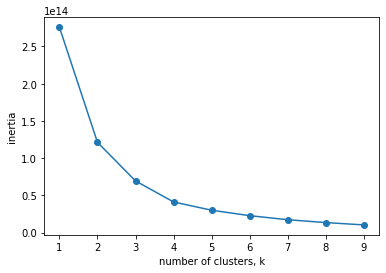

In [ ]:
ks = range(1,10)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(train.drop('credit', axis=1))
    inertias.append(model.inertia_)

    

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
train

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,credit,gender_car_reality,phones_email,income_total_bins,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_BIRTH_year,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,DAYS_EMPLOYED_year,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_year,begin_year,begin_week,AGE,mean_income_20대평균소득미만,mean_income_20대평균소득이상,mean_income_30대평균소득미만,mean_income_30대평균소득이상,mean_income_40대평균소득미만,mean_income_40대평균소득이상,mean_income_50대평균소득미만,mean_income_50대평균소득이상,mean_income_60대평균소득미만,mean_income_60대평균소득이상,cluster
0,0,202500,0,1,1,2,13899,4709,12,2,6,1,0,0,0,7,1,1158,0,0,392,9190,6,0,766,0,26,38,0,0,0,1,0,0,0,0,0,0,4
1,1,247500,0,4,0,1,11380,1540,8,3,5,1,1,1,0,7,1,948,3,0,128,9840,4,1,820,0,21,31,0,0,0,1,0,0,0,0,0,0,4
2,0,450000,4,1,1,1,19087,4434,10,2,22,2,7,2,1,0,2,1591,3,1,370,14653,8,1,1221,1,95,52,0,0,0,0,0,0,0,1,0,0,1
3,0,202500,0,4,1,1,15088,2092,15,2,37,0,1,2,0,10,3,1257,9,2,174,12996,1,0,1083,3,160,41,0,0,0,0,0,1,0,0,0,0,4
4,0,157500,2,1,1,1,15037,2105,10,2,26,2,3,0,0,9,0,1253,10,0,175,12932,11,3,1078,2,112,41,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,225000,2,4,1,1,12079,1984,3,4,2,1,0,0,0,6,1,1007,6,3,165,10095,0,2,842,0,8,33,0,0,0,1,0,0,0,0,0,0,4
26453,1,180000,4,1,2,1,15291,2475,12,2,47,2,1,0,0,5,0,1274,10,1,206,12816,7,2,1068,3,204,42,0,0,0,0,1,0,0,0,0,0,0
26454,0,292500,4,4,0,5,10082,2015,3,2,25,2,2,0,0,0,0,840,7,3,168,8067,4,0,672,2,108,28,0,1,0,0,0,0,0,0,0,0,4
26455,0,171000,4,2,3,1,10145,107,8,1,59,2,5,0,0,2,1,845,3,3,9,10038,10,2,836,4,256,28,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
test

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,gender_car_reality,phones_email,income_total_bins,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_BIRTH_year,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,DAYS_EMPLOYED_year,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week,before_EMPLOYED_year,begin_year,begin_week,AGE,mean_income_20대평균소득미만,mean_income_20대평균소득이상,mean_income_30대평균소득미만,mean_income_30대평균소득이상,mean_income_40대평균소득미만,mean_income_40대평균소득이상,mean_income_50대평균소득미만,mean_income_50대평균소득이상,mean_income_60대평균소득미만,mean_income_60대평균소득이상,cluster
0,0,112500,1,4,0,1,21990,0,12,2,60,6,2,0,1,1,1832,0,0,0,21990,1,1,1832,5,260,60,0,0,0,0,0,0,0,0,1,0,2
1,0,135000,2,1,1,1,18964,8671,3,2,36,1,2,0,8,1,1580,1,2,723,10293,7,2,857,3,156,52,0,0,0,0,0,0,1,0,0,0,0
2,0,69372,4,4,1,1,15887,217,8,2,40,1,6,0,1,1,1324,7,3,18,15670,6,2,1306,3,173,44,0,0,0,0,1,0,0,0,0,0,2
3,0,112500,0,4,1,1,19270,2531,4,2,41,6,4,0,6,0,1606,0,1,211,16739,5,3,1395,3,178,53,0,0,0,0,0,0,1,0,0,0,2
4,0,225000,2,1,1,1,17822,9385,10,2,8,3,4,0,6,2,1485,0,0,782,8437,5,1,703,0,34,49,0,0,0,0,0,1,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,202500,4,2,1,1,18593,5434,0,2,19,3,6,0,7,0,1549,1,0,453,13159,6,3,1096,1,82,51,0,0,0,0,0,0,0,1,0,0,4
9996,0,202500,4,4,0,1,10886,1315,8,2,34,7,4,0,2,3,907,7,3,110,9571,7,3,797,2,147,30,0,0,0,1,0,0,0,0,0,0,4
9997,0,292500,4,4,1,1,21016,14018,11,2,55,1,0,0,4,2,1751,11,2,1168,6998,5,3,583,4,238,58,0,0,0,0,0,0,0,1,0,0,4
9998,0,180000,0,4,1,1,16541,1085,12,2,33,2,2,0,11,3,1378,0,3,90,15456,11,0,1288,2,143,45,0,0,0,0,1,0,0,0,0,0,0


# DACON 코드공유

In [ ]:
pip install optuna

In [ ]:
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
import optuna

In [ ]:
X = train.drop(["credit"], axis=1)
y = train["credit"]
X_test = test.copy()

In [ ]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.01,
        "n_estimators": 15000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        'boosting_type': 'gbdt',
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=900,
        verbose=False,
    )

    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)
    
    return log_score

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-05-23 18:12:11,114] A new study created in memory with name: lgbm_parameter_opt
[I 2021-05-23 18:13:27,361] Trial 0 finished with value: 0.7281965511117017 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.7281965511117017.
[I 2021-05-23 18:14:40,245] Trial 1 finished with value: 0.6941374311111144 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.6941374311111144.
[I 2021-05-23 18:16:05,593] Trial 2 finished with value: 0.7196380418860033 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambd

Best Score: 0.6941374311111144
Best trial: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}


In [ ]:
# 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "max_depth",
        "num_leaves",
        "colsample_bytree",
        "subsample",
        "subsample_freq",
        "min_child_samples",
        "max_bin",
    ],
)


In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

# 자체 모델

In [ ]:
{"random_state": 42,"verbosity": -1,"learning_rate": 0.01,"n_estimators": 150000,"objective": "multiclass","metric": "multi_logloss",'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}
dacon_param = {"random_state": 42,"verbosity": -1,"learning_rate": 0.01,"n_estimators": 15000,"objective": "multiclass","metric": "multi_logloss",'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}

In [ ]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [ ]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 38) (26457, 1) (10000, 38)


In [ ]:
import tensorflow as tf

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 42)

clf = LGBMClassifier(**dacon_param)
clf.fit(X_train,y_train,eval_set=[(X_train, y_train), (X_valid, y_valid)],early_stopping_rounds=900,verbose=False)
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_valid)

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(tf.keras.utils.to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

KeyboardInterrupt: ignored

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission.to_csv('[PAUL]]Day0_myselfKfold10.csv', index=False)

- scaler & 차원 축소

In [ ]:
"""
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

scaler.fit(test)
test_scaled = scaler.transform(test)


from sklearn.decomposition import PCA

pca = PCA(n_components=31)
pca1 = PCA(n_components=30)

pca.fit(train_scaled)
train_pca = pca.transform(train_scaled)

pca1.fit(test_scaled)
test_pca = pca1.transform(test_scaled)

train_pca = pd.DataFrame(train_pca,columns = train.columns)
test_pca = pd.DataFrame(test_pca,columns = test.columns)
"""

'\nfrom sklearn.preprocessing import StandardScaler, RobustScaler\nfrom sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nscaler.fit(train)\ntrain_scaled = scaler.transform(train)\n\nscaler.fit(test)\ntest_scaled = scaler.transform(test)\n\n\nfrom sklearn.decomposition import PCA\n\npca = PCA(n_components=31)\npca1 = PCA(n_components=30)\n\npca.fit(train_scaled)\ntrain_pca = pca.transform(train_scaled)\n\npca1.fit(test_scaled)\ntest_pca = pca1.transform(test_scaled)\n\ntrain_pca = pd.DataFrame(train_pca,columns = train.columns)\ntest_pca = pd.DataFrame(test_pca,columns = test.columns)\n'

- kmeans smote

In [ ]:
#KMeansSMOTE(random_state=42, cluster_balance_threshold=0.1)

In [ ]:
#X_res, y_res = sm.fit_resample(X, y)

# 모델1

In [ ]:
n_fold = 5
seed = 20

best_params = {'colsample_bytree': 0.5,
 'learning_rate': 0.035,
 'max_depth': 14,
 'min_child_weight': 7,
 'n_estimators': 150000,
 'reg_alpha': 3,
 'reg_lambda': 1,
 'subsample': 0.9500000000000001,
 'tree_learner': 'serial',
 'objective': 'multiclass',
 'boosting_type': 'goss',
 'metrics': 'multi_logloss'
 }

lgbm_params = {
    'metric': 'multi_logloss',
    'objective': 'multiclass',
    'n_estimators': 50000,
    'learning_rate': 0.01,
    'max_depth': 21,
    'boosting_type': 'goss',
    'colsample_bytree': 0.7,
    'subsample': 0.8,
    'bagging_freq': 1,
    'num_leaves': 189 ,
    'subsample' :1,
}

lgbm_params1 = {'objective': 'multiclass',
              'boosting_type': 'goss', # goss # dart #rf
              'metrics': 'multi_logloss',
              'n_estimators' : 150000 ,
              'learning_rate':0.01,
              'subsample':0.6,
              'tree_learner': 'serial',
              'colsample_bytree':0.5,
              'bagging_freq': 1,
              'num_leaves': 128 ,
              #'reg_alpha' : 0.3,
              #'reg_lambda' :0.5 
              'subsample' :1
            }            

lgbm_params2 = {'objective': 'multiclass',
              'boosting_type': 'gbdt',
              'metrics': 'multi_logloss',
              'n_estimators' : 150000,
              'learning_rate':0.01,
              'num_leaves':7,
              'subsample':0.9,
              'max_depth': 4,
              'colsample_bytree':0.7,
              'min_child_samples': 100,
              'scale_pos_weight':150,
              'bagging_freq': 1,
            }

lgbm_params3 = {'objective': 'multiclass',
              'boosting_type': 'gbdt', # goss
              'metrics': 'multi_logloss',
              'n_estimators' : 50000 ,
              'learning_rate':0.01,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.8,
              'bagging_freq': 1,
              'num_leaves': 181 ,
              'reg_alpha' : 0.3,
              'reg_lambda' :0.5,
              #'subsample' :0.95
            }

cat_param = {'n_estimators' : 100000,
             'learning_rate': 0.01,
             #'depth':12,
             'random_seed':31,
             #'od_type':'Iter',
             #'od_wait':100,
             'bootstrap_type' :'Bernoulli',
             }

opt_param = {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
random.seed(seed)
kfold_models={}
for fold in range(10):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,train['credit'][train_idx].values, train['credit'][valid_idx].values 
    #smote = SMOTE(random_state=0)
    #X_train,y_train = smote.fit_sample(X_train,y_train)
    model = LGBMClassifier(**opt_param) #**lgbm_params, **lgbm_params1, **best_params
    #model = LGBMClassifier(n_estimators=15000,num_leaves=64,boosting_type='goss',max_depth=22,learning_rate=0.01,n_jobs=-1,boost_from_average=False)
    #model = CatBoostClassifier(**cat_param)
    #model = CatBoostClassifier(random_state=20,learning_rate= 0.01,iterations=100000,depth=10,bootstrap_type ='Bernoulli')
    #model = LGBMClassifier(metrics='multi_logloss',objective='multiclass',n_estimators=150,learning_rate=0.1,boosting_type ='dart',max_depth=5,min_child_weight=0.1, num_leaves=30,random_state=9697,n_jobs=-1)
    model.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_valid, y_valid)],early_stopping_rounds=900,verbose=100)
    kfold_models[fold]=model
    print(f'========================================================================================')

====================================1============================================
Training until validation scores don't improve for 900 rounds.
[100]	training's multi_logloss: 0.755442	valid_1's multi_logloss: 0.791429
[200]	training's multi_logloss: 0.681082	valid_1's multi_logloss: 0.751294
[300]	training's multi_logloss: 0.626241	valid_1's multi_logloss: 0.728766
[400]	training's multi_logloss: 0.581786	valid_1's multi_logloss: 0.712473
[500]	training's multi_logloss: 0.545308	valid_1's multi_logloss: 0.702489
[600]	training's multi_logloss: 0.5135	valid_1's multi_logloss: 0.696037
[700]	training's multi_logloss: 0.485897	valid_1's multi_logloss: 0.691478
[800]	training's multi_logloss: 0.461152	valid_1's multi_logloss: 0.68762
[900]	training's multi_logloss: 0.439505	valid_1's multi_logloss: 0.685957
[1000]	training's multi_logloss: 0.419394	valid_1's multi_logloss: 0.686056
[1100]	training's multi_logloss: 0.401079	valid_1's multi_logloss: 0.686985
[1200]	training's multi_logloss

In [ ]:
submission.iloc[:,1:]=0
for fold in range(10):
    submission.iloc[:,1:] += kfold_models[fold].predict_proba(test)/10

In [ ]:
submission.to_csv('[FINAL]DAY0_KFOLD10_BESTLGBM.csv', index=False)

In [ ]:
submission

,index,0,1,2
0,26457,0.070888,0.257616,0.671496
1,26458,0.373937,0.241988,0.384075
2,26459,0.029219,0.068567,0.902215
3,26460,0.172539,0.118555,0.708906
4,26461,0.161346,0.340681,0.497973
...,...,...,...,...
9995,36452,0.082697,0.427754,0.489550
9996,36453,0.237062,0.216969,0.545969
9997,36454,0.044444,0.112166,0.843390
9998,36455,0.181580,0.368841,0.449578


# 앙상블

- voting classification

In [ ]:
meta_voting = VotingClassifier(estimators = [('s_lgbm',s_lgbm ), ('s_ext', s_ext),('s_xgb',s_xgb)], voting='soft')
meta_voting.fit(S_train, y_train)
meta_pred = meta_voting.predict_proba(S_test)